In [1]:
import pandas as pd
import numpy as np
import pickle
import statsmodels.api as sm
from sklearn import metrics

import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
%matplotlib inline

In [3]:
# Dla bazy danych heart
df = pd.read_csv("data/heart.csv")
print(df.shape)
df.head()
target = "TenYearCHD"
numFeatures = ['age', 'totChol', 'cigsPerDay', 'diaBP',' sysBP', 'BMI', 'heartRate', 'glucose']
catFeatures = [ 'male', 'education', 'currentSmoker',  'BPMeds', 'prevalentStroke', 'prevalentHyp',  'diabetes']

(3656, 16)


In [4]:
from sklearn import preprocessing

In [5]:
features = df.columns.tolist()
features.remove(target)
#print(features)

In [6]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


# Przygotujmy wrapper
def CVTestRFClass(nFolds = 5, randomState=2020, debug=False, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # listy do przechowywania wyników:
    testResults = []
    trainResults = []
    predictions = []
    indices = []

    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = RandomForestClassifier(*args, **kwargs, random_state=randomState, n_jobs=-1)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie dopasowania za pomocą metryki ROC-AUC
        trainScore = roc_auc_score((df[target].iloc[train]==1).astype(int), predsTrain)
        testScore = roc_auc_score((df[target].iloc[test]==1).astype(int), preds)
        
        # Zapisanie wyników do listy 
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices

In [8]:
trainResults, testResults, predictions, indices = CVTestRFClass(debug=True)
print(np.mean(testResults))

RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 1.0 Valid AUC: 0.7109836305173926
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 1.0 Valid AUC: 0.7074943396226415
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 1.0 Valid AUC: 0.7053003300330032
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 1.0 Valid AUC: 0.6952415728728125
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 1.0 Valid AUC: 0.6792638055778863
0.6996567357247472


In [9]:
# Pętla po parametrze n_estimators
for k in [10, 25, 50, 100, 200, 500, 1000, 2000, 5000]:
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

10 0.9995049383152628 0.654441245952992 0.34506369236227075
25 0.9999978498734899 0.684975782793875 0.3150220670796149
50 1.0 0.6967501820803316 0.30324981791966843
100 1.0 0.6996567357247472 0.3003432642752528
200 1.0 0.7068478997246166 0.2931521002753834
500 1.0 0.7098007410678168 0.29019925893218323
1000 1.0 0.713312569831927 0.28668743016807297
2000 1.0 0.7146819809012184 0.28531801909878163
5000 1.0 0.7149566245857633 0.28504337541423674


Im więcej tym lepiej. Brak wyraźnej poprawy na więcej niż 1000 drzew. Zostawiamy 1000 drzew.

In [10]:
for k in range(2,22,2):
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=1000, max_depth=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

2 0.7350686287861714 0.7130499584474758 0.022018670338695645
4 0.7745375333430269 0.7208074729058008 0.05373006043722606
6 0.8362362592650177 0.7249365266501059 0.11129973261491177
8 0.9146588812546816 0.7240269987457782 0.1906318825089034
10 0.9770188113982409 0.7222699855173069 0.25474882588093395
12 0.998473788154491 0.720374730846356 0.278099057308135
14 0.9999992774690464 0.7176021055781632 0.2823971718908832
16 1.0 0.716691287223918 0.28330871277608205
18 1.0 0.7140450230107974 0.2859549769892026
20 1.0 0.716942456221789 0.283057543778211


Różnica gwałtownie rośnie wraz ze wzrostem głębokości. Dla 6 wydaje się najlepiej.

In [11]:
for k in range(2, len(features) + 1,2):
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=1000, max_depth=6,
                                                                    max_features=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

2 0.8297637153722457 0.7225065677577361 0.10725714761450955
4 0.839636139652266 0.7240592076527872 0.11557693199947883
6 0.8431357171290275 0.7231420732245833 0.11999364390444411
8 0.8447555742662154 0.7241463532036864 0.12060922106252903
10 0.8450186114349272 0.7234477596454788 0.12157085178944838
12 0.845366580463744 0.7233716758535892 0.12199490461015483
14 0.8454338905938062 0.722015977717812 0.12341791287599424


Najlepsze dla 8 zmiennych.

In [12]:
for k in [2, 4, 6, 8, 10, 15, 20, 30]:
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=1000, max_depth=6,
                                                                    max_features=8,
                                                                    min_samples_split=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

2 0.8447555742662154 0.7241463532036864 0.12060922106252903
4 0.8427531991375012 0.7234606990493546 0.11929250008814662
6 0.8396445992094648 0.724019837228085 0.11562476198137972
8 0.8367490990219417 0.7233709628050736 0.1133781362168681
10 0.8339749363352439 0.7234221739975777 0.1105527623376662
15 0.8285287905218898 0.7235369644190028 0.10499182610288693
20 0.8245272822402484 0.7237948095737898 0.10073247266645857
30 0.818534007498193 0.7235967878559 0.09493721964229307


Nie ma dużych różnic. Wybieramy 2.

In [14]:
for k in [1, 2, 4, 6, 8, 10, 15, 20, 30]:
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=1000, max_depth=6,
                                                                    max_features=8,
                                                                    min_samples_split=2, min_samples_leaf=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

1 0.8447555742662154 0.7241463532036864 0.12060922106252903
2 0.8453561082056025 0.7244746670785063 0.1208814411270962
4 0.843317062945748 0.7247877619370412 0.11852930100870684
6 0.8399871096567999 0.7243019116851179 0.11568519797168197
8 0.8368258959862012 0.7246095465018476 0.11221634948435355
10 0.833446522483771 0.7244091282300866 0.10903739425368442
15 0.826257572769601 0.7240037128627073 0.10225385990689373
20 0.8199049391752314 0.723956819858782 0.09594811931644942
30 0.8084021713028611 0.7230802724674328 0.08532189883542829


Coraz mniejsze przetrenowanie. Minimalnie najlepszy wynik dla 4.

In [35]:
trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=1000, max_depth=6,
                                                                    max_features=8,
                                                                    min_samples_split=2, min_samples_leaf=4)
print(np.mean(testResults))

modelRF = {
    "name":"RF",
    "description":"Model RF, ze zmiennymi kategorycznymi z LE",
    "specification":'n_estimators=500, max_depth=20, max_features=4, min_samples_split=4, min_samples_leaf=1',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.7247877619370412


Poprawa z 0.699 na 0.725

In [36]:
import pickle

# Otwieramy plik do zapisu binarnego z wykorzystenim with
with open("model_RF_1.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(modelRF, fp)

---

##### Random search

In [26]:
# Przygotujmy listę do zapisywnia wyników
results = []

In [27]:
import random
# Teraz napiszmy pętle, w której będziemy iterować kolejne wyszukiwania.
for k in range(50):
    # Przygotujmy słownik parametrów
    # Jako punkt odniesienia do wybranych przedziałów posłużą nam wcześniejsze wyniki
    params = {
        "max_depth" : random.randint(7, 18),
        "max_features" : random.randint(2, 10),
        "min_samples_split" : random.randint(2, 15),
    }
    # Wartość min_samples_leaf musi być mniejsza niż min_samples_split
    params["min_samples_leaf"] = random.randint(1, params["min_samples_split"])
    
    # Estymacja modelu dla wylosowanych hiperparametrów
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=100,
                                                                    max_depth=params["max_depth"],
                                                                    max_features=params["max_features"],
                                                                    min_samples_split=params["min_samples_split"],
                                                                    min_samples_leaf=params["min_samples_leaf"])
    
    # Zapiszmy wynik
    results.append((np.mean(testResults), params.copy()))
    
    # Wyświetlmy wynik bieżącej iteracji
    print(params, np.mean(testResults))
    
    # Co 10 iteracji wyświetlmy sobie nasze dotychczasowe top 5
    if k>1 and k%10==0:    
        print("\n Top 5:")
        for score, params in sorted(results, key=lambda x: x[0], reverse=True)[0:5]:
            print(params, score)
        print()

{'max_depth': 14, 'max_features': 5, 'min_samples_split': 8, 'min_samples_leaf': 5} 0.719340716398358
{'max_depth': 14, 'max_features': 4, 'min_samples_split': 13, 'min_samples_leaf': 10} 0.7229659972420723
{'max_depth': 16, 'max_features': 9, 'min_samples_split': 10, 'min_samples_leaf': 5} 0.715025009545061
{'max_depth': 7, 'max_features': 5, 'min_samples_split': 7, 'min_samples_leaf': 3} 0.7220028024360906
{'max_depth': 17, 'max_features': 8, 'min_samples_split': 12, 'min_samples_leaf': 2} 0.7103878835450447
{'max_depth': 14, 'max_features': 7, 'min_samples_split': 15, 'min_samples_leaf': 13} 0.7171226783125153
{'max_depth': 11, 'max_features': 10, 'min_samples_split': 13, 'min_samples_leaf': 11} 0.7206881930240449
{'max_depth': 17, 'max_features': 9, 'min_samples_split': 10, 'min_samples_leaf': 5} 0.7138276547526337
{'max_depth': 9, 'max_features': 4, 'min_samples_split': 6, 'min_samples_leaf': 6} 0.7234355808104654
{'max_depth': 9, 'max_features': 3, 'min_samples_split': 7, 'min_sa

In [32]:
for score, params in sorted(results, key=lambda x: x[0], reverse=True)[0:1]:
            print(params, score)

{'max_depth': 7, 'max_features': 4, 'min_samples_split': 7, 'min_samples_leaf': 4} 0.7253215716091982


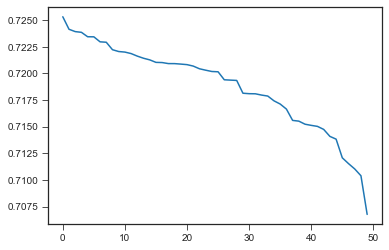

In [28]:
# Zobaczmy jak wyglądają wyniki od najlepszego graficznie
plt.plot([x for x, y in sorted(results, key=lambda x: x[0], reverse=True)])

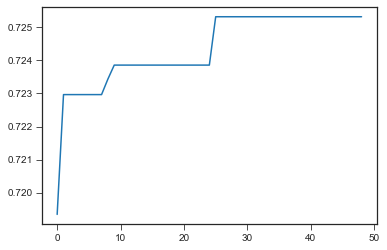

In [29]:
# Możemy tez zobaczyć jak z czasem poprawiał się najlepszy wynik:
bestHistory = []
for k in range(1,len(results)):
    # List comprehension: dla k pierwszych wartości zwróć maximum
    bestHistory.append(np.max([x for x, y in sorted(results[:k], key=lambda x: x[0], reverse=True)]))
# Wykres historii
plt.plot(bestHistory)

---

Estymacja na znalezionych parametrach.

In [37]:
trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=1000, max_depth=7,
                                                                    max_features=4,
                                                                    min_samples_split=7, min_samples_leaf=4)
print(np.mean(testResults))

modelRF_rs = {
    "name":"RF_rs",
    "description":"Model RF, ze zmiennymi kategorycznymi z LE",
    "specification":'n_estimators=1000, max_depth=7, max_features=4, min_samples_split=7, min_samples_leaf=4',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.7259494023768782


In [38]:
# Otwieramy plik do zapisu binarnego z wykorzystenim with
with open("model_RF_1_rs.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(modelRF_rs, fp)

---